# Assignment Advanced Regression

### Import Libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
%matplotlib inline

### Data Cleaning

In [2]:
housing_data = pd.read_csv('train.csv')

In [3]:
housing_data.shape

(1460, 81)

In [4]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
housing_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
### Handling NULL values
round(housing_data.isnull().sum()/len(housing_data.index),2).sort_values(ascending=False).head(10)

PoolQC          1.00
MiscFeature     0.96
Alley           0.94
Fence           0.81
FireplaceQu     0.47
LotFrontage     0.18
GarageYrBlt     0.06
GarageFinish    0.06
GarageType      0.06
GarageQual      0.06
dtype: float64

In [7]:
### Dropping columns with more than 15% nulls
round(housing_data.isnull().sum()/len(housing_data.index),2)[round(housing_data.isnull().sum()/
                                                                 len(housing_data.index),2).values>0.15]

LotFrontage    0.18
Alley          0.94
FireplaceQu    0.47
PoolQC         1.00
Fence          0.81
MiscFeature    0.96
dtype: float64

In [8]:
housing_data = housing_data.drop(['LotFrontage','Alley','FireplaceQu','PoolQC','Fence','MiscFeature','MoSold'],axis='columns')

#### Lets convert the year columns to age values. Eg. if YearBuilt max year is 2010 and YearBuilt is 2000 then YearBuild_Age = 2010 - 2000 = 10

In [9]:
housing_data['YearBuilt_Age'] = housing_data.YearBuilt.max()-housing_data.YearBuilt
housing_data['YearRemodAdd_Age'] = housing_data.YearRemodAdd.max()-housing_data.YearRemodAdd
housing_data['GarageYrBlt_Age'] = housing_data.GarageYrBlt.max()-housing_data.GarageYrBlt
housing_data['YrSold_Age'] = housing_data.YrSold.max()-housing_data.YrSold

In [10]:
housing_data[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','YearBuilt_Age','YearRemodAdd_Age',
             'GarageYrBlt_Age','YrSold_Age']].head(10)

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,YearBuilt_Age,YearRemodAdd_Age,GarageYrBlt_Age,YrSold_Age
0,2003,2003,2003.0,2008,7,7,7.0,2
1,1976,1976,1976.0,2007,34,34,34.0,3
2,2001,2002,2001.0,2008,9,8,9.0,2
3,1915,1970,1998.0,2006,95,40,12.0,4
4,2000,2000,2000.0,2008,10,10,10.0,2
5,1993,1995,1993.0,2009,17,15,17.0,1
6,2004,2005,2004.0,2007,6,5,6.0,3
7,1973,1973,1973.0,2009,37,37,37.0,1
8,1931,1950,1931.0,2008,79,60,79.0,2
9,1939,1950,1939.0,2008,71,60,71.0,2


In [11]:
### Dropping actual year columns
housing_data = housing_data.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis='columns')

### Handle Missing Values

In [12]:
housing_data.MasVnrType.fillna('None',inplace=True)
housing_data.MasVnrArea.fillna(housing_data.MasVnrArea.mean(),inplace=True)
housing_data.BsmtQual.fillna('TA',inplace=True)
housing_data.BsmtCond.fillna('TA',inplace=True)
housing_data.BsmtExposure.fillna('No',inplace=True)
housing_data.BsmtFinType1.fillna('Unf',inplace=True)
housing_data.BsmtFinType2.fillna('Unf',inplace=True)
housing_data.GarageType.fillna('Attchd',inplace=True)
housing_data.GarageYrBlt_Age.fillna(-1,inplace=True)
housing_data.GarageFinish.fillna('Unf',inplace=True)
housing_data.GarageQual.fillna('TA',inplace=True)
housing_data.GarageCond.fillna('TA',inplace=True)

In [13]:
housing_data.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt_Age,YearRemodAdd_Age,GarageYrBlt_Age,YrSold_Age
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,1057.429452,...,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890,38.732192,25.134247,29.691096,2.184247
std,421.610009,42.300571,9981.264932,1.382997,1.112799,180.569112,456.098091,161.319273,441.866955,438.705324,...,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883,30.202904,20.645407,25.121824,1.328095
min,1.000000,20.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,0.000000,0.000000,-1.000000,0.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000,10.000000,6.000000,7.000000,1.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000,37.000000,16.000000,25.500000,2.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000,56.000000,43.000000,48.000000,3.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000,138.000000,60.000000,110.000000,4.000000


As per analysis, 'Street' and 'Utilities' is explaining the lowest variance, thus dropping these.

In [14]:
housing_data.Street.value_counts()
housing_data.Utilities.value_counts()
housing_data = housing_data.drop(['Street','Utilities'],axis='columns')

In [15]:
# id column is also not of use, thus dropping
housing_data = housing_data.drop('Id',axis='columns')

## EDA

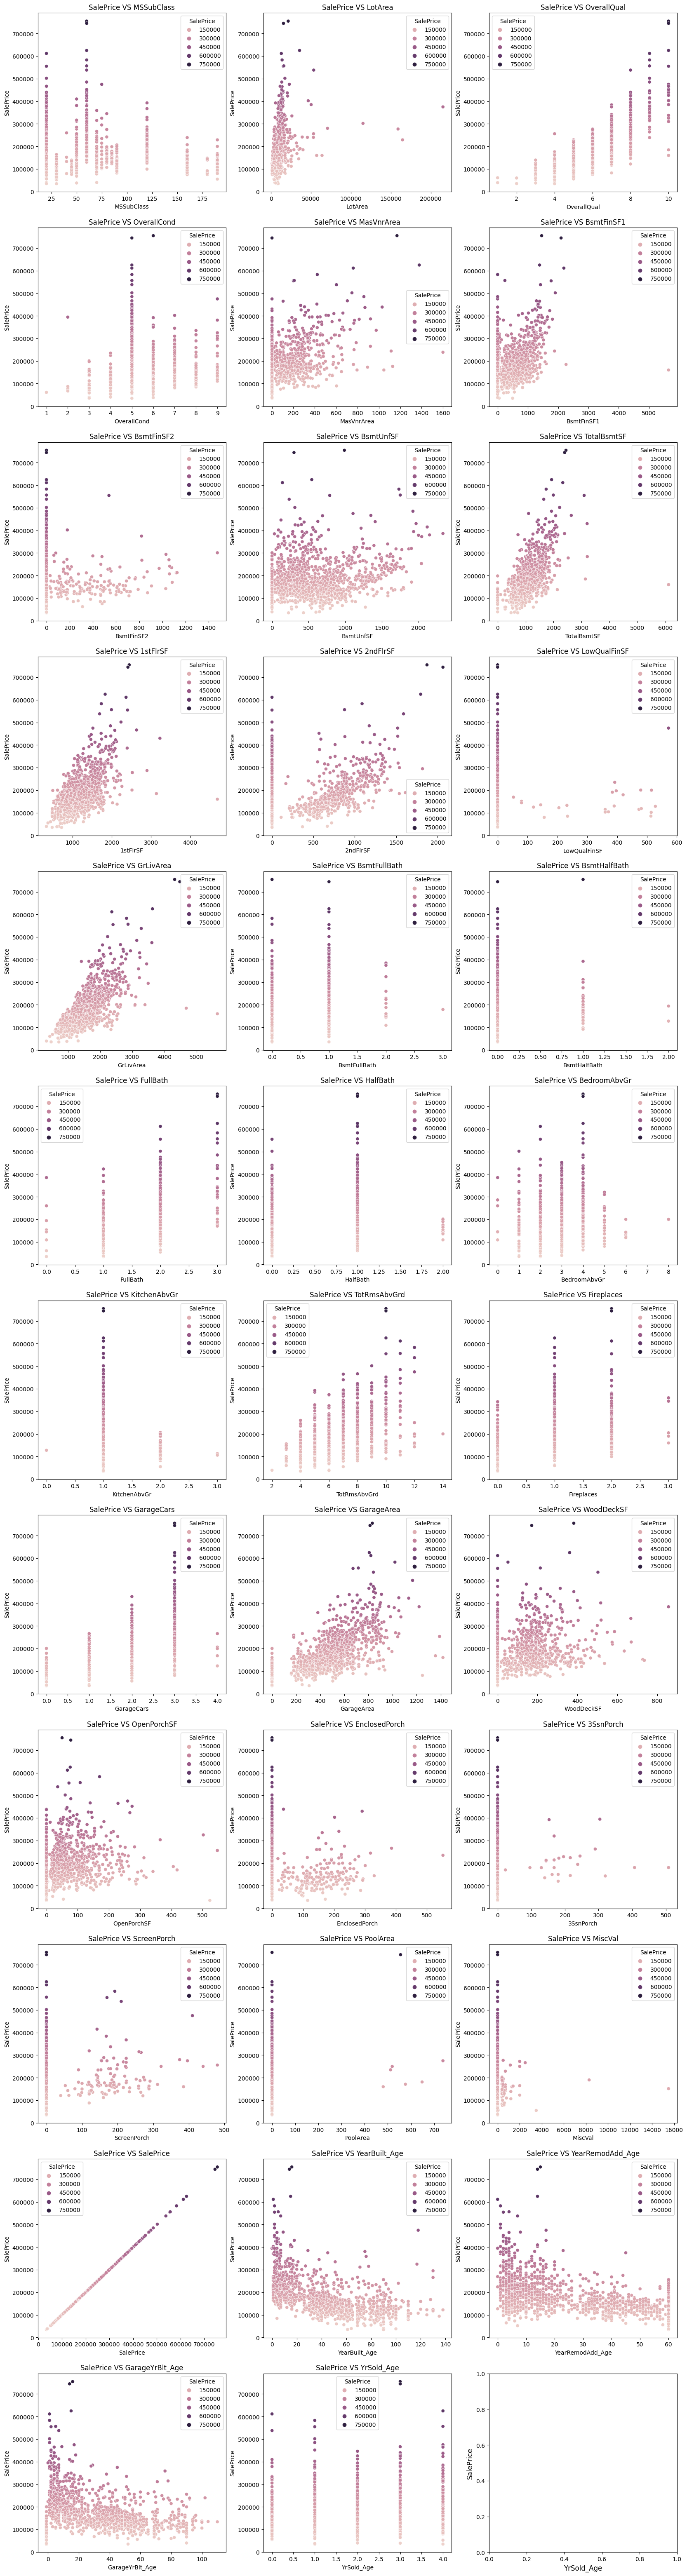

In [16]:
#Visualising numerical predictor variables with Target Variables
df_num = housing_data.select_dtypes(include=['int64','float64'])
fig,axs= plt.subplots(12,3,figsize=(20,80))
for i,ax in zip(df_num.columns,axs.flatten()):
    sns.scatterplot(x=i, y='SalePrice', hue='SalePrice',data=df_num,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_title('SalePrice'+' VS '+str(i))

#### Observations:
- Newer houses are costlier than older houses. 
- GRLiving Area has a direct corelation with the price of the property.
- Total basement area, which is linearly related with the total living area, also is directly proportional to the price of the property.

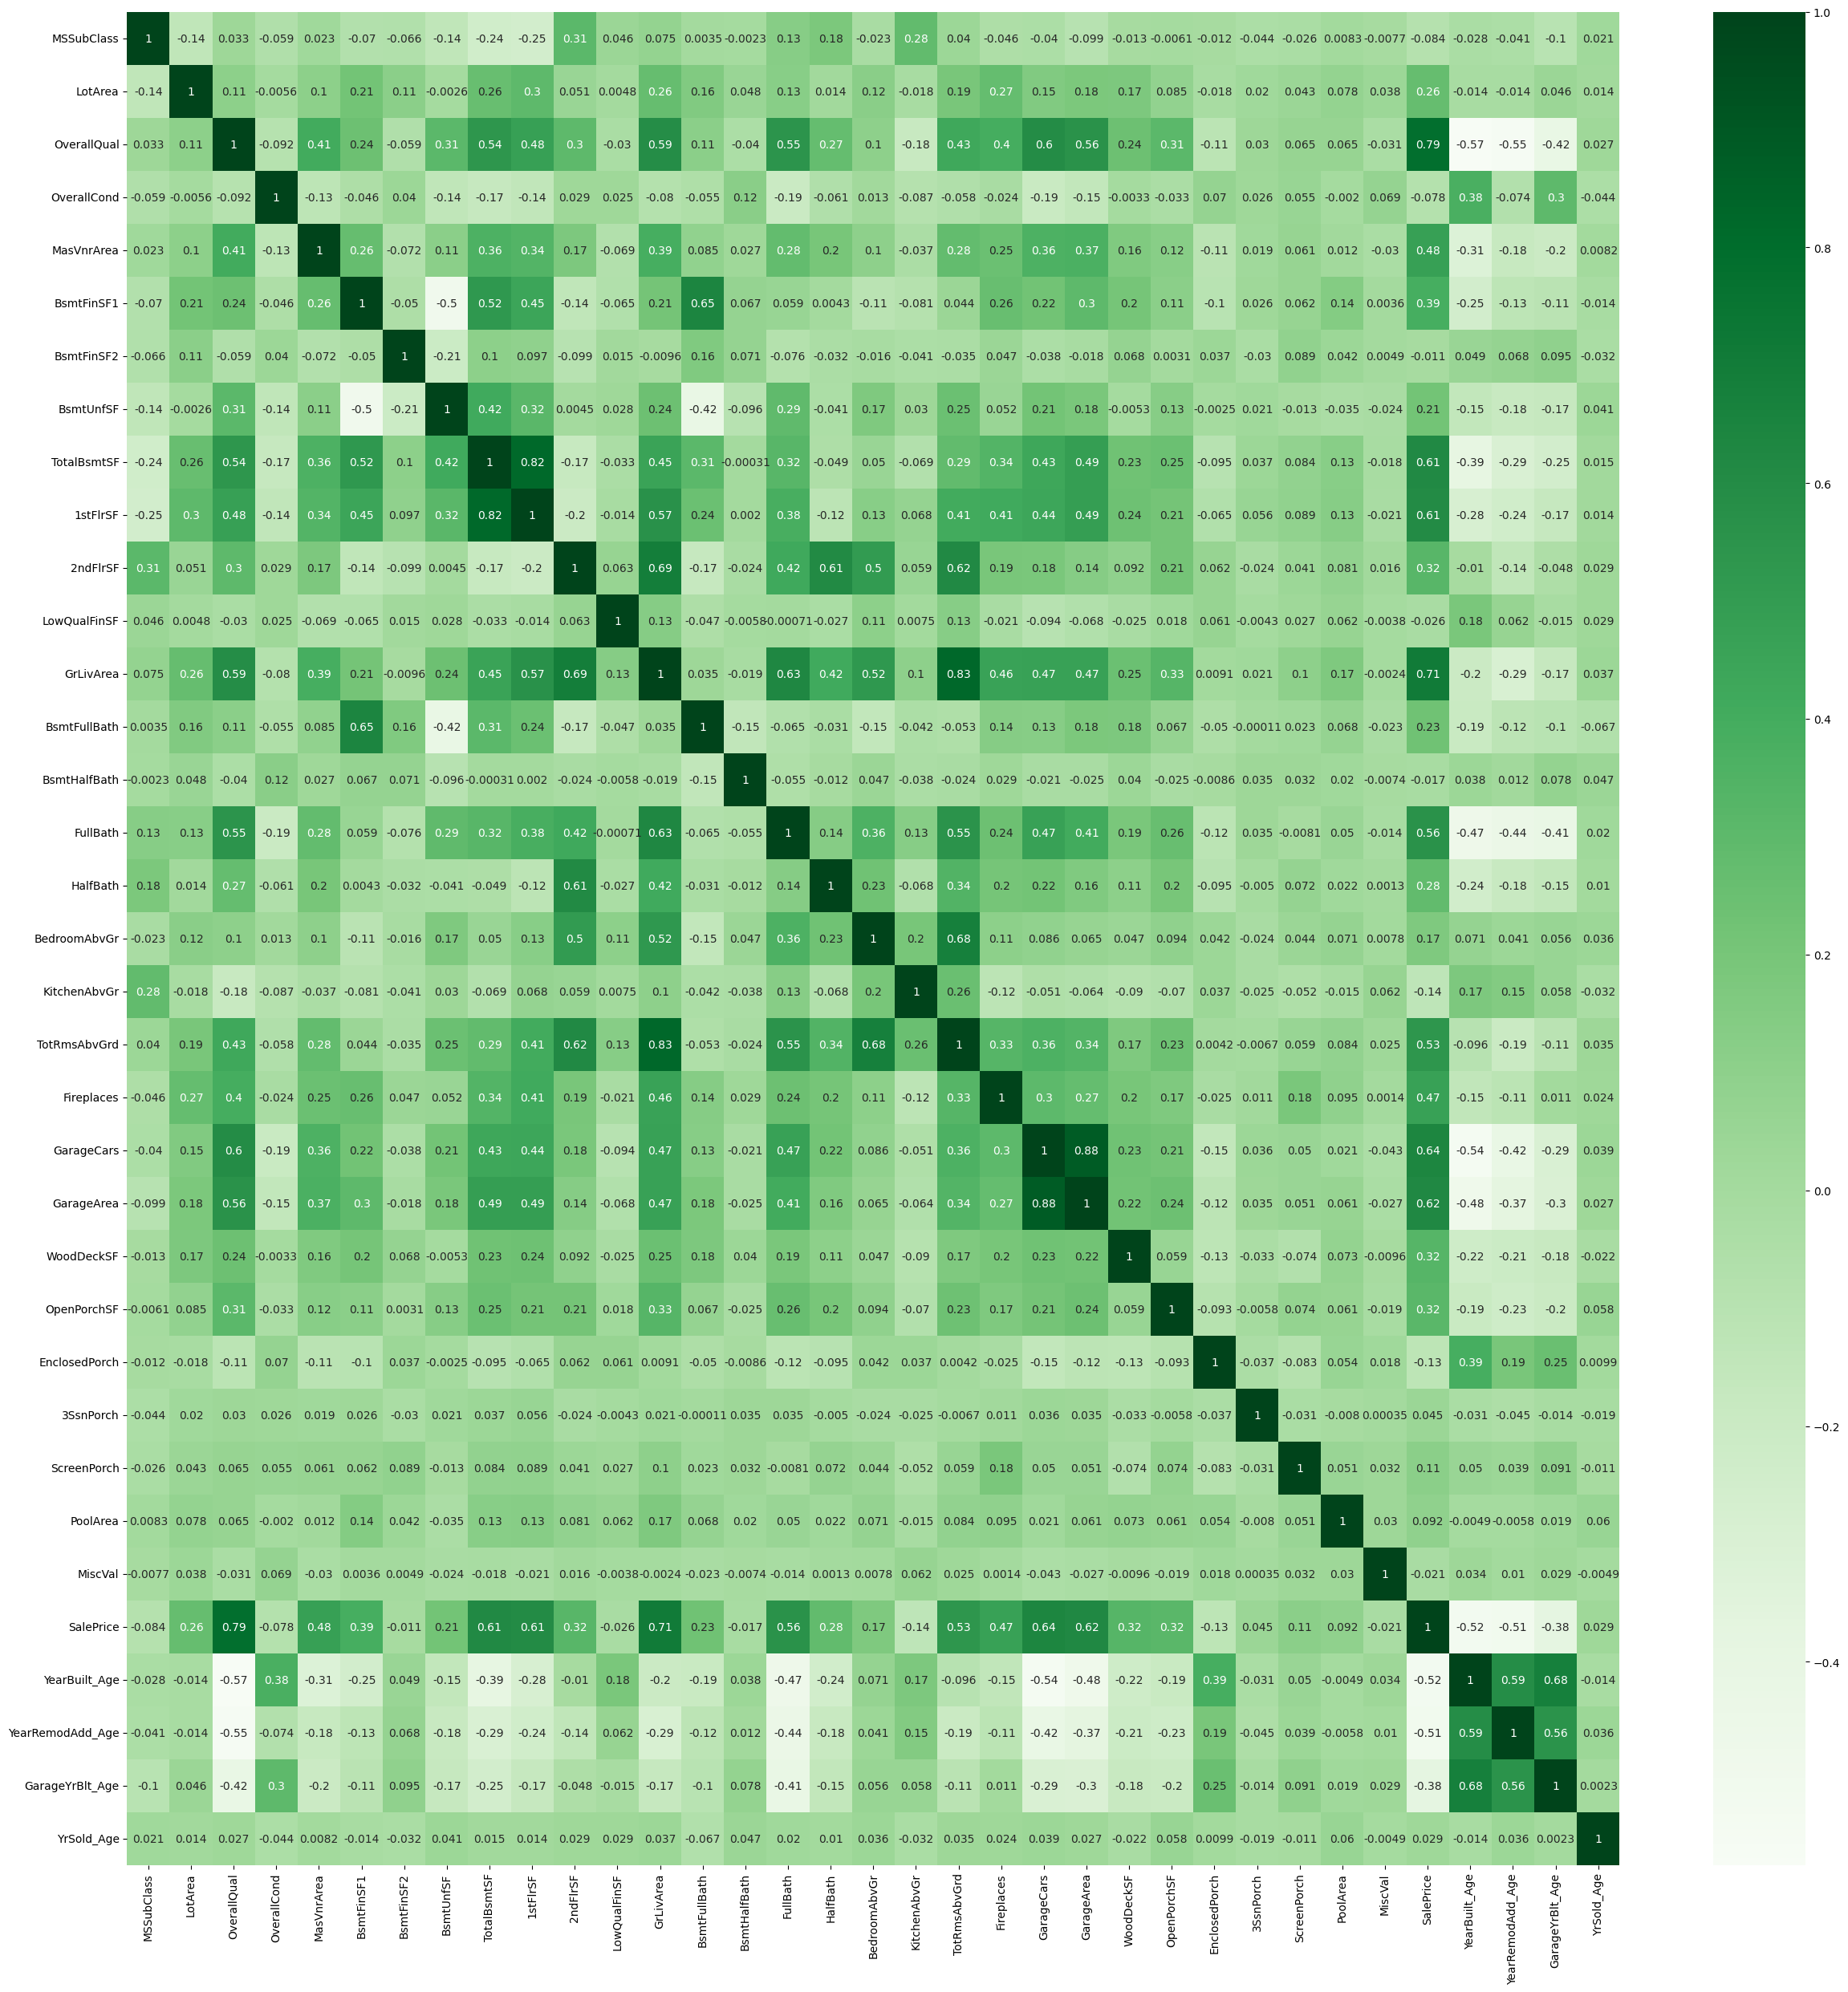

In [17]:
plt.figure(figsize=(30,30))
sns.heatmap(housing_data[list(housing_data.dtypes[housing_data.dtypes!='object'].index)].corr(),annot=True,cmap='Greens')
plt.show()

#### Observations
- SalePrice is highly correlated with OverallQual, TotalBsmtSF,GrLivArea,GarageCars,GarageArea

### Outlier Treatment
Lower Quartile - 0.25
Upper Quartile - 0.99

In [18]:
housing_data.shape

(1460, 71)

In [19]:
num_col = list(housing_data.dtypes[housing_data.dtypes !='object'].index)
num_col = ['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF','GrLivArea','OpenPorchSF',
           'EnclosedPorch','3SsnPorch',
           'ScreenPorch' ,'PoolArea','MiscVal','SalePrice']
def drop_outliers(x):
    list = []
    for col in num_col:
        Q1 = x[col].quantile(.25)
        Q3 = x[col].quantile(.99)
        IQR = Q3-Q1
        x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    return x   

housing_data = drop_outliers(housing_data)

In [20]:
housing_data.shape

(1441, 71)

In [21]:
housing_data[list(housing_data.dtypes[housing_data.dtypes=='object'].index)].head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [22]:
housing_data[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,Gtl,Gd,Gd,TA,No,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,Reg
1,Gtl,TA,Gd,TA,Gd,ALQ,Unf,Ex,Y,TA,RFn,TA,TA,TA,Reg
2,Gtl,Gd,Gd,TA,Mn,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1
3,Gtl,TA,TA,Gd,No,ALQ,Unf,Gd,Y,Gd,Unf,TA,TA,TA,IR1
4,Gtl,Gd,Gd,TA,Av,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1


#### We can conclude by observing that these have some kind of order thus it is ordinal in nature

In [23]:
## Converting the columns
housing_data['LandSlope'] = housing_data.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
housing_data['ExterQual'] = housing_data.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_data['BsmtQual'] = housing_data.BsmtQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_data['BsmtCond'] = housing_data.BsmtCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_data['BsmtExposure'] = housing_data.BsmtExposure.map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
housing_data['BsmtFinType1'] = housing_data.BsmtFinType1.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
housing_data['BsmtFinType2'] = housing_data.BsmtFinType2.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
housing_data['HeatingQC'] = housing_data.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_data['CentralAir'] = housing_data.CentralAir.map({'N':0,'Y':1})
housing_data['KitchenQual'] = housing_data.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_data['GarageFinish'] = housing_data.GarageFinish.map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
housing_data['GarageQual'] = housing_data.GarageQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_data['GarageCond'] = housing_data.GarageCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_data['ExterCond'] = housing_data.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_data['LotShape'] = housing_data.LotShape.map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})

In [24]:
housing_data[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,0,3,4,3,1,6,1,4,1,3,2,3,3,2,3
1,0,2,4,3,4,5,1,4,1,2,2,3,3,2,3
2,0,3,4,3,2,6,1,4,1,3,2,3,3,2,0
3,0,2,3,4,1,5,1,3,1,3,1,3,3,2,0
4,0,3,4,3,3,6,1,4,1,3,2,3,3,2,0


### Creating Dummies

In [25]:
## Creating and joining with dummy dataset
dummy_col = pd.get_dummies(housing_data[['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition']],
                           drop_first=True)

housing_data = pd.concat([housing_data,dummy_col],axis='columns')

housing_data = housing_data.drop(['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition'],axis='columns')

### Split - Train and Test Dataset

In [26]:
# using random_state=42 as it is recommended
df_train,df_test = train_test_split(housing_data,train_size=0.7,test_size=0.3,random_state=42)

In [27]:
housing_data[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,0,3,4,3,1,6,1,4,1,3,2,3,3,2,3
1,0,2,4,3,4,5,1,4,1,2,2,3,3,2,3
2,0,3,4,3,2,6,1,4,1,3,2,3,3,2,0
3,0,2,3,4,1,5,1,3,1,3,1,3,3,2,0
4,0,3,4,3,3,6,1,4,1,3,2,3,3,2,0


In [28]:
## Scaling the train dataset
num_col = ['MSSubClass','LotArea','OverallQual','OverallCond',
           'MasVnrArea','BsmtFinSF1',
           'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
           'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
           'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',
           'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
           'ScreenPorch','PoolArea','MiscVal','SalePrice']

scaler = StandardScaler()
df_train[num_col] = scaler.fit_transform(df_train[num_col])
df_test[num_col] = scaler.transform(df_test[num_col])

#### Splitting the dependent and independent variable

In [29]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [30]:
y_test = df_test.pop('SalePrice')
X_test = df_test

### Performing Recursive Feature Elimination- RFE

In [31]:
len(X_train.columns)

192

Note : We cannot use RFE with GridSearchCV as 192 variable with 5 folds will create 960 fit and it will take time, thus using RFE directly

In [32]:
lm  = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,n_features_to_select=30)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=30)

In [33]:
rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

In [34]:
rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)

In [35]:
## Filtering Train and Test sets for RFE selected columns
X_train = X_train[rfe_sel_columns]
X_test = X_test[rfe_sel_columns]

## Lasso Regression Model

In [36]:
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8479098486229748
0.818211575106701


In [37]:
model_parameter = list(lm.coef_)
model_parameter.insert(0,lm.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = df_train.columns
col.insert(0,'Constant')
list(zip(col,model_parameter))

[('MSSubClass', -1.21),
 ('LotArea', 0.292),
 ('LotShape', 0.3),
 ('LandSlope', 0.369),
 ('OverallQual', 0.261),
 ('OverallCond', 0.271),
 ('MasVnrArea', 0.0),
 ('ExterQual', 0.28),
 ('ExterCond', 0.106),
 ('BsmtQual', 0.5),
 ('BsmtCond', 0.632),
 ('BsmtExposure', 0.457),
 ('BsmtFinType1', -1.719),
 ('BsmtFinSF1', -0.254),
 ('BsmtFinType2', -0.288),
 ('BsmtFinSF2', -0.377),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', 0.0),
 ('HeatingQC', -0.0),
 ('CentralAir', 1.646),
 ('1stFlrSF', -0.098),
 ('2ndFlrSF', -0.0),
 ('LowQualFinSF', -0.0),
 ('GrLivArea', -0.0),
 ('BsmtFullBath', 0.264),
 ('BsmtHalfBath', 0.002),
 ('FullBath', -0.0),
 ('HalfBath', 0.44),
 ('BedroomAbvGr', 0.0),
 ('KitchenAbvGr', 0.173),
 ('KitchenQual', -0.106)]

#### Improve model using GridSearchCV  with optimal value of alpha

In [38]:
folds = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001, 0.01, 0.1,1.0, 5.0, 10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [39]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.004582,0.004861,0.002829,0.004306,0.001,{'alpha': 0.001},0.789357,0.867580,0.804105,0.829227,...,0.849373,0.849337,0.847980,0.848033,0.848232,0.859354,0.848987,0.844224,0.849304,0.003892
1,0.004454,0.003176,0.002920,0.003712,0.010,{'alpha': 0.01},0.743999,0.831546,0.790642,0.798078,...,0.800194,0.799808,0.796643,0.795967,0.795957,0.821444,0.800356,0.792763,0.800288,0.007684
2,0.008592,0.006348,0.000547,0.001641,0.100,{'alpha': 0.1},0.612893,0.768342,0.710673,0.706974,...,0.721014,0.727348,0.727182,0.725823,0.721840,0.751570,0.725565,0.722769,0.727813,0.008655
3,0.000000,0.000000,0.004756,0.007266,1.000,{'alpha': 1.0},-0.006496,-0.021566,-0.018063,-0.001154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.007667,0.007679,0.000110,0.000331,5.000,{'alpha': 5.0},-0.006496,-0.021566,-0.018063,-0.001154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


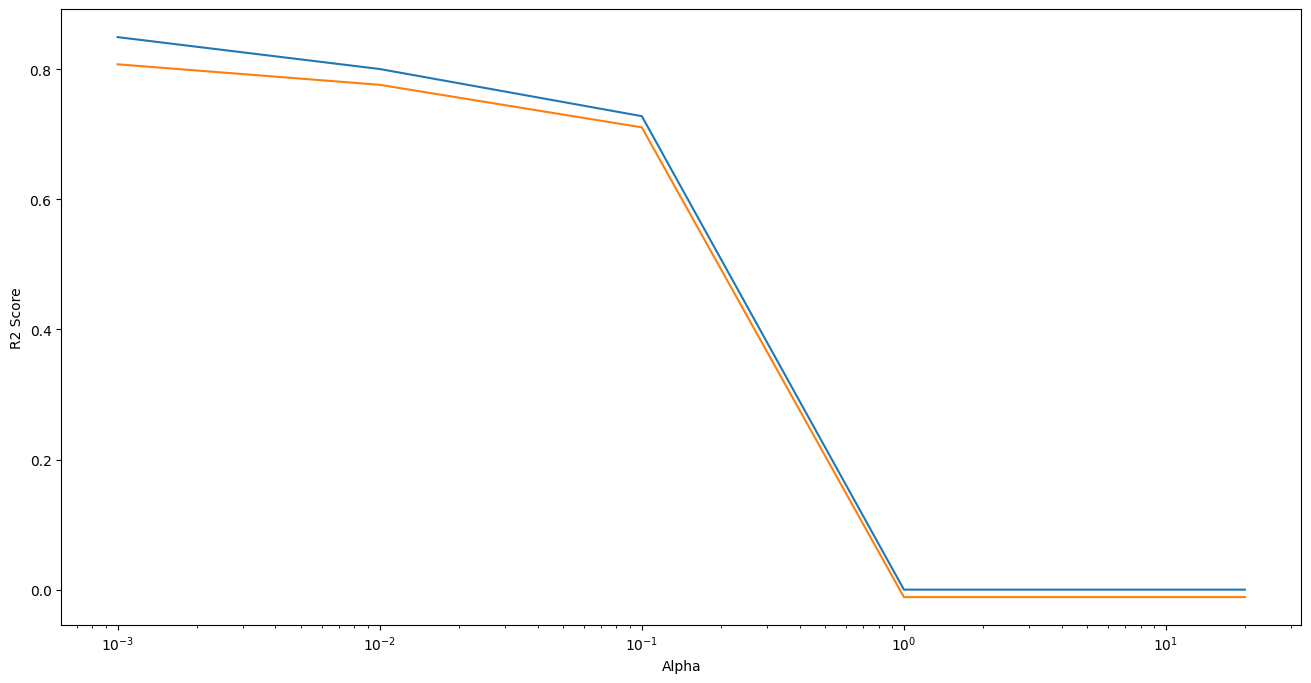

In [40]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [41]:
# Checking the best alpha value
model_cv.best_params_

{'alpha': 0.001}

In [42]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8479098486229748
0.818211575106701


In [43]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = df_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Featuere','Coef']
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Featuere,Coef
19,CentralAir,1.645997
10,BsmtCond,0.632334
9,BsmtQual,0.499979
11,BsmtExposure,0.457274
27,HalfBath,0.439566
3,LandSlope,0.368861
2,LotShape,0.299974
1,LotArea,0.292389
7,ExterQual,0.280363
5,OverallCond,0.270993


In [44]:
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Featuere,Coef
19,CentralAir,1.645997
10,BsmtCond,0.632334
9,BsmtQual,0.499979
11,BsmtExposure,0.457274
27,HalfBath,0.439566
3,LandSlope,0.368861
2,LotShape,0.299974
1,LotArea,0.292389
7,ExterQual,0.280363
5,OverallCond,0.270993


## Ridge Regression Model

In [45]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
print(r2_score(y_train,y_train_pred))
y_test_pred = ridge.predict(X_test)
print(r2_score(y_test,y_test_pred))

0.8534727906510267
0.8058802621519441


Note: we can observe that above alpha value is not optimal.<br>
Let's find the optimal value of alpha and improve model using GridSearchCV

In [46]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001,0.01,0.1,0.2,0.5,0.9,1.0, 5.0, 10.0,20.0]}

model = Ridge()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1.0, 5.0,
                                   10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [47]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.002768,0.003930,0.004612,0.006175,0.001,{'alpha': 0.001},0.798732,0.865099,0.774333,0.837771,...,0.855972,0.854619,0.853542,0.854060,0.854056,0.863974,0.854169,0.849434,0.854794,0.003635
1,0.003598,0.002590,0.001306,0.001301,0.010,{'alpha': 0.01},0.798724,0.865132,0.776405,0.837707,...,0.855969,0.854618,0.853541,0.854059,0.854055,0.863973,0.854168,0.849433,0.854793,0.003635
2,0.004179,0.006160,0.004737,0.007027,0.100,{'alpha': 0.1},0.798624,0.865414,0.793914,0.837108,...,0.855740,0.854559,0.853474,0.853994,0.853988,0.863942,0.854104,0.849371,0.854717,0.003638
3,0.006303,0.007722,0.000000,0.000000,0.200,{'alpha': 0.2},0.798486,0.865638,0.808111,0.836512,...,0.855194,0.854405,0.853303,0.853825,0.853816,0.863862,0.853936,0.849210,0.854523,0.003653
4,0.001160,0.003480,0.001562,0.004686,0.500,{'alpha': 0.5},0.797951,0.865898,0.832022,0.835055,...,0.852874,0.853617,0.852447,0.852963,0.852949,0.863451,0.853072,0.848387,0.853579,0.003773


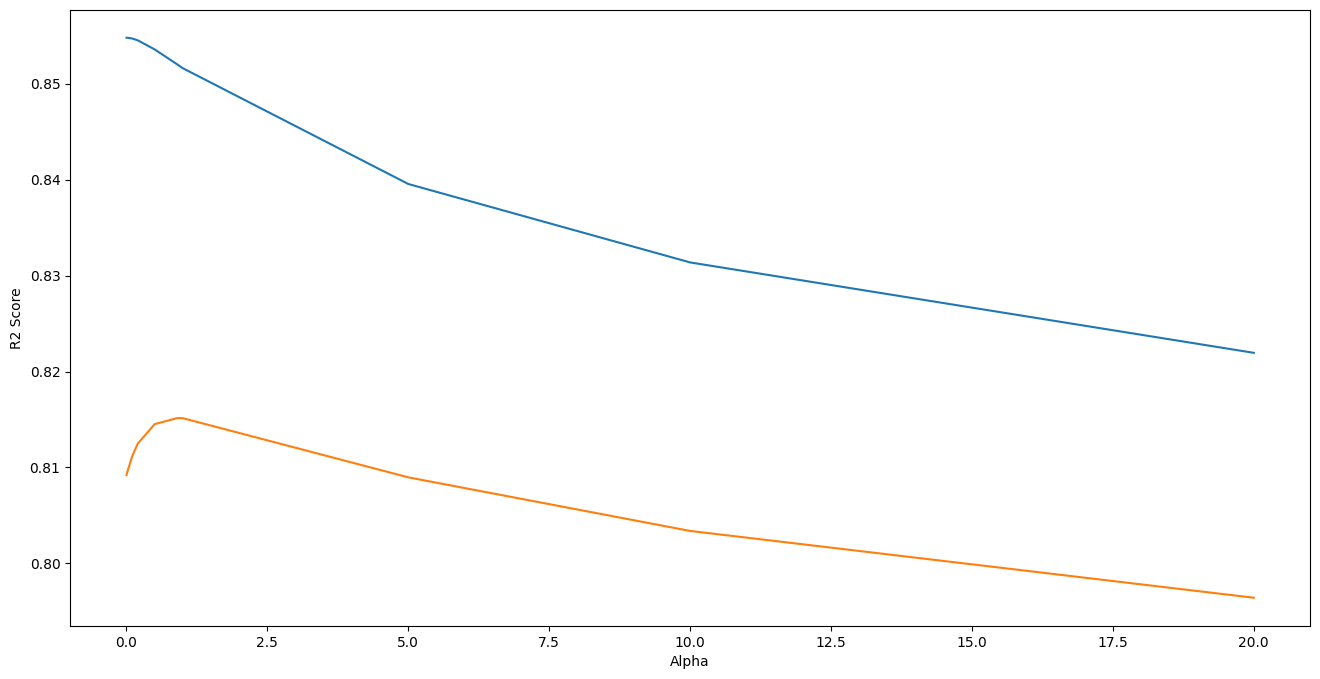

In [48]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.show()

#### With the above graph, lets create the model

In [49]:
# Checking the best alpha value
model_cv.best_params_

{'alpha': 0.9}

In [50]:
ridge = Ridge(alpha = 0.9)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.8512268074783247
0.8157240337525367


In [51]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = df_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feaure','Coef']

In [52]:
ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feaure,Coef
19,CentralAir,1.550823
10,BsmtCond,0.653478
9,BsmtQual,0.516658
11,BsmtExposure,0.515016
27,HalfBath,0.497876
17,TotalBsmtSF,0.393632
3,LandSlope,0.369550
16,BsmtUnfSF,0.320384
7,ExterQual,0.307797
2,LotShape,0.303644


### Preferring lasso over ridge:
<p>We can observe that r2_scores are almost same in ridge and lasso, but since lasso would penalize more on dataset and help in feature elimination thus, using Lasso as final training model.</p>

In [53]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8479098486229748
0.818211575106701


After comparing both models, these are the best features explaining the dataset.
- CentralAir: Central air conditioning
- BsmtCond: the general condition of the basement
- BsmtQual: the height of the basement
- BsmtExposure: Refers to walkout or garden level walls
- HalfBath: Half baths above grade
- TotalBsmtSF: Total square feet of basement area
- LandSlope: Slope of property

Best Value for alpha:
- Lasso : 0.001
- Ridge : 0.9

### Part 2 Assignment :

In [54]:
## What if alpha is doubled?
### Lasso
lasso = Lasso(alpha=0.002)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.843238116080688
0.8230719338643002


In [55]:
### Ridge
ridge = Ridge(alpha = 1.8)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.8481463335238923
0.820914014014055


#### Ridge Previous Values (alpha 0.9):
0.8512268074783247
0.8157240337525367
#### Ridge New Values (alpha: 1.8):
0.8481463335238923
0.820914014014055

----

#### Lasso Previous Values (alpha 0.001):
0.8479098486229748
0.818211575106701
#### Lasso New Values (alpha: 0.002):
0.843238116080688
0.8230719338643002

We can conclude that ridge is affected slightly more with the alpha change.

#### Building new lasso model by excluding the top 5 predictor variables for Question 3

In [56]:
df_train_new = df_train.drop(['CentralAir','BsmtCond','BsmtQual','BsmtExposure','HalfBath'],axis='columns')

In [57]:
df_test_new = df_test.drop(['CentralAir','BsmtCond','BsmtQual','BsmtExposure','HalfBath'],axis='columns')

In [58]:
#y_train = df_train.pop('SalePrice')
X_train_new = df_train_new

In [59]:
#y_test = df_test.pop('SalePrice')
X_test_new = df_test_new

In [60]:
lm  = LinearRegression()
lm.fit(X_train_new,y_train)
rfe = RFE(lm,n_features_to_select=30)
rfe.fit(X_train_new,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=30)

In [61]:
rfe_scores = pd.DataFrame(list(zip(X_train_new.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

In [62]:
rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)
rfe_sel_columns

['OverallQual',
 'ExterQual',
 'TotalBsmtSF',
 'GrLivArea',
 'LotConfig_CulDSac',
 'Neighborhood_Edwards',
 'Neighborhood_IDOTRR',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_StoneBr',
 'Condition2_PosN',
 'Condition2_RRNn',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'RoofStyle_Shed',
 'RoofMatl_Membran',
 'RoofMatl_Roll',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior2nd_AsphShn',
 'Foundation_Stone',
 'Heating_Wall',
 'Functional_Maj2',
 'Functional_Sev',
 'SaleType_ConLI',
 'SaleType_New',
 'SaleType_Oth']

In [63]:
## Filtering Train and Test sets for RFE selected columns
X_train_new = X_train_new[rfe_sel_columns]
X_test_new = X_test_new[rfe_sel_columns]

In [64]:
folds = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001, 0.01, 0.1,1.0, 5.0, 10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train_new,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [65]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.004315,0.005270,0.000835,0.000894,0.001,{'alpha': 0.001},0.800035,0.862549,0.787378,0.847368,...,0.851570,0.847765,0.849537,0.850198,0.845966,0.860302,0.848748,0.844574,0.849480,0.004268
1,0.002034,0.004765,0.004289,0.006635,0.010,{'alpha': 0.01},0.753465,0.827102,0.796774,0.810831,...,0.802244,0.799689,0.800144,0.799684,0.796069,0.824875,0.802006,0.795215,0.802331,0.008016
2,0.004817,0.003190,0.001051,0.000912,0.100,{'alpha': 0.1},0.684776,0.781530,0.736054,0.733655,...,0.745853,0.751018,0.750256,0.750167,0.741610,0.777999,0.748396,0.743775,0.751130,0.009868
3,0.003845,0.006077,0.001661,0.004660,1.000,{'alpha': 1.0},-0.006496,-0.021566,-0.018063,-0.001154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.004722,0.006511,0.001001,0.003004,5.000,{'alpha': 5.0},-0.006496,-0.021566,-0.018063,-0.001154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


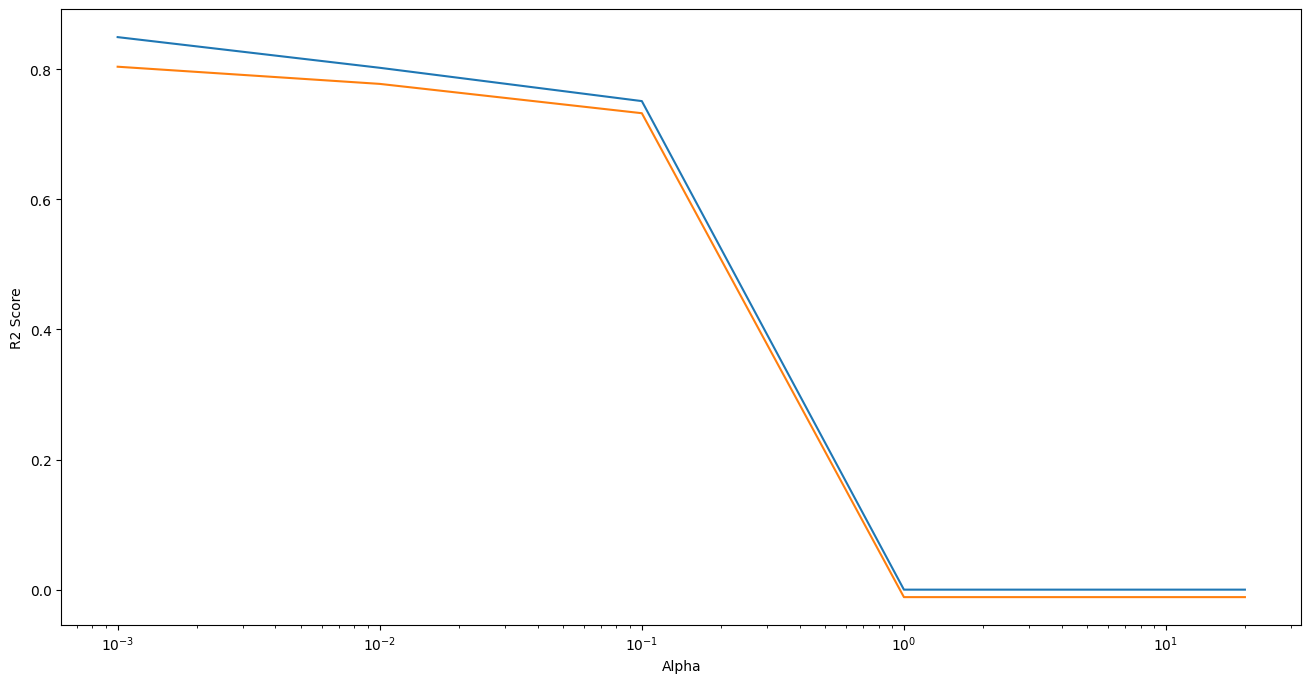

In [66]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [67]:
model_cv.best_params_

{'alpha': 0.001}

In [68]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_new,y_train)

y_train_pred = lasso.predict(X_train_new)
y_test_pred = lasso.predict(X_test_new)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8478437410014087
0.8247674739238495


In [69]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = df_train_new.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Featuere','Coef']

In [70]:
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Featuere,Coef
22,FullBath,1.674631
8,ExterCond,0.570775
11,BsmtFinType2,0.397174
4,OverallQual,0.368824
2,LotShape,0.276218
1,LotArea,0.271996
5,OverallCond,0.249381
29,GarageCars,0.213903
3,LandSlope,0.164061
20,BsmtFullBath,-0.000000


#### New top 5 predictors are 
- FullBath: Full bathrooms above grade
- ExterCond: Evaluates the present condition of the material on the exterior
- BsmtFinType2: Rating of basement finished area
- OverallQual: Rates the overall material and finish of the house
- LotShape: General shape of property